In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
MLFLOW = False

In [18]:
import pandas as pd
from pathlib import Path

def load_all_metrics_files(path):
    """
    Parcourt tous les sous-dossiers de `path`, charge les fichiers `df_metrics.csv`,
    et les combine en un seul DataFrame global.

    Parameters:
    - path (Path): Le chemin du dossier racine à parcourir.

    Returns:
    - pd.DataFrame: Le DataFrame global combinant tous les fichiers `df_metrics.csv`.
    """
    path = Path(path)
    all_metrics = []  # Liste pour stocker tous les DataFrames

    # Parcourir tous les sous-dossiers et rechercher les fichiers df_metrics.csv
    for file in path.rglob('df_metrics.csv'):
        try:
            # Charger le fichier CSV dans un DataFrame
            df = pd.read_csv(file)

            # Ajouter une colonne pour identifier la source du fichier
            df['source'] = str(file.parent)  # Ajouter le chemin du dossier parent

            # Ajouter le DataFrame à la liste
            all_metrics.append(df)
        except Exception as e:
            print(f"Erreur lors du chargement de {file}: {e}")

    # Combiner tous les DataFrames en un seul DataFrame global
    if all_metrics:
        df_global = pd.concat(all_metrics, ignore_index=True)
    else:
        df_global = pd.DataFrame()  # Si aucun fichier trouvé, retourne un DataFrame vide

    return df_global

if not MLFLOW:
    # Utilisation de la fonction
    path = Path('../GNN/firemen/firepoint/2x2/test/occurence_default')
    df = load_all_metrics_files(path)

In [19]:
if MLFLOW:
    metric = 'bad_prediction_modified_nbsinister_max_1'
    df = pd.read_csv(f'{metric}.csv')

    metric = 'wildfire_over_predicted_modified_nbsinister_max_1'
    df1 = pd.read_csv(f'{metric}.csv')

    metric = 'iou_modified_nbsinister_max_1'
    df2 = pd.read_csv(f'{metric}.csv')

    metric = 'apr_nbsinister_max_1'
    df3 = pd.read_csv(f'{metric}.csv')

    metric = 'r2_nbsninster_max_1'
    df4 = pd.read_csv(f'{metric}.csv')

    df = df.set_index('Run').join(df1.set_index('Run')['wildfire_over_predicted_modified_nbsinister_max_1']).reset_index()
    df = df.set_index('Run').join(df2.set_index('Run')['iou_modified_nbsinister_max_1']).reset_index()
    df = df3.set_index('Run').join(df2.set_index('Run')['apr_nbsinister_max_1']).reset_index()
    df = df4.set_index('Run').join(df2.set_index('Run')['r2_nbsninster_max_1']).reset_index()

    #df.dropna(subset=['temporal_spearman', 'temporal_mae', 'temporal_binary_f1', 'temporal_kendall'], inplace=True)
    df.drop_duplicates(inplace=True, keep='first')
    df.reset_index(drop=True, inplace=True)

In [20]:
def parse_run_name(x):
    dico = {}
    vec = x.split('_')
    dico['Department'] = vec[0]
    dico['Model'] = vec[1]
    i = 2
    if dico['Model']  == 'fwi':
        i += 1
        dico['Target'] = 'indice'
    else:
        dico['Target'] = vec[i]
        i += 1
    if dico['Model'] != 'fwi':
        dico['Task_type'] = vec[i]
        i += 1
        dico['loss'] = vec[i]
        i += 1
        if vec[i] == 'features':
            i += 1
    else:
        dico['loss'] = None
        dico['Task_type'] = 'Indice'

    dico['Number_of_samples'] = vec[i]
    i += 1
    dico['k_days'] = vec[i]
    i += 1
    dico['Number_of_features'] = vec[i]
    i += 1
    dico['Scale'] = vec[i]
    i += 1
    dico['Days_in_futur'] = vec[i]
    i += 1
    dico['Base'] = vec[i]
    i += 1
    dico['Method'] = vec[i]
    i += 1
    if dico['i'] == 'kmeans':
        i += 1
        dico['kmeans_cluster'] = vec[i]
        i += 1
        dico['kmeans_thresh'] = vec[i]
        i += 1
    dico['weight'] = vec[i]
    return dico

# Initialisation des colonnes avec des valeurs None
df['Department'] = None
df['Model'] = None
df['Target'] = None
df['Task_type'] = None
df['Loss_function'] = None
df['Number_of_samples'] = None
df['kdays'] = None
df['Number_of_features'] = None
df['Scale'] = None
df['Base'] = None
df['Method'] = None
df['Days_in_futur'] = None
df['weight'] = None
df['kmeans_thresh'] = None
df['kmeans_cluster'] = None

# Boucle pour remplir les colonnes avec les valeurs de dico_parse
for index, row in df.iterrows():
    dico_parse = parse_run_name(row['Run'])
    
    # Mise à jour de chaque colonne avec les valeurs du dictionnaire dico_parse
    df.loc[index, 'Department'] = dico_parse.get('Department')
    df.loc[index, 'Model'] = dico_parse.get('Model')
    df.loc[index, 'Target'] = dico_parse.get('Target')
    df.loc[index, 'Task_type'] = dico_parse.get('Task_type')
    df.loc[index, 'Loss_function'] = dico_parse.get('loss')
    df.loc[index, 'Number_of_samples'] = dico_parse.get('Number_of_samples')
    df.loc[index, 'kdays'] = dico_parse.get('kdays')
    df.loc[index, 'Number_of_features'] = dico_parse.get('Number_of_features')
    df.loc[index, 'Scale'] = dico_parse.get('Scale')
    df.loc[index, 'Base'] = dico_parse.get('Base')
    df.loc[index, 'Method'] = dico_parse.get('Method')
    df.loc[index, 'Days_in_futur'] = dico_parse.get('Days_in_futur')

    df.loc[index, 'weight'] = dico_parse.get('weight')
    df.loc[index, 'kmeans_thresh'] = dico_parse.get('kmeans_thresh', 0)
    df.loc[index, 'kmeans_cluster'] = dico_parse.get('kmeans_cluster', 0)

In [27]:
import seaborn as sns

def compare_models2(df, depts, dept_markers, metrics, col_to_analyse, dir_output, suffix):
    task_types = df[col_to_analyse].unique()

    np.random.seed(42)  # Pour rendre le code reproductible (vous pouvez le changer ou le retirer)
    colors = sns.color_palette("husl", len(task_types))  # Palette de couleurs diversifiée et aléatoire

    #Associer chaque modèle à une couleur
    task_colors = dict(zip(task_types, colors))
    # Create a new figure for all departments
    fig, axs = plt.subplots(len(depts), len(metrics), figsize=(15, 3 * len(depts)), sharey='row')

    # Loop through each department
    for dept_index, dept in enumerate(depts):
        # Filtering the DataFrame for a specific department
        df_filtered = df[df['Department'].isin([dept])].reset_index()

        # Loop through each metric to create a subplot for each metric
        for metric_index, metric in enumerate(metrics):
            ax = axs[dept_index, metric_index] if len(depts) > 1 else axs[metric_index]
            for method in task_types:
                subset = df_filtered[df_filtered[col_to_analyse] == method]

                if len(subset) == 0:
                    continue

                subset = subset.sort_values(col_to_analyse)
                
                # Add label only for the first occurrence of each method
                label = method if dept_index == 0 else None  # Only show labels for the first department
                ax.plot(subset[col_to_analyse].values, subset[metric].values, marker=dept_markers[dept], linestyle='-', 
                        label=label, color=task_colors[method])  # Use task type color
                
            # Configuration for each subplot
            ax.set_ylim(0, 1)
            ax.set_xlabel('Scale')
            if dept_index == 0:  # Only set the title for the first row
                ax.set_title(f'{metric}', fontsize=12)
            #ax.set_xticks(subset[col_to_analyse].values, rotation=45)
            ax.grid(True)

        axs[dept_index, 0].set_ylabel('Metric Value')

    # Create a custom legend for task types and departments
    task_handles = [plt.Line2D([0], [0], color=task_colors[method], label=method) for method in task_types]
    dept_handles = [plt.Line2D([0], [0], marker=dept_markers[dept], linestyle='None', color='black', label=dept) for dept in depts]

    # Combine both legends
    fig.legend(handles=task_handles + dept_handles, loc='center left', bbox_to_anchor=(0.85, 0.85), title="Legend")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.savefig(dir_output / f'{col_to_analyse}_{suffix}.png')
    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def compare_models_3d(df, depts, dept_markers, metrics, col_to_analyse_1, col_to_analyse_2):
    """
    Compare models in 3D based on two columns and multiple metrics for different departments.
    
    :param df: DataFrame containing the data.
    :param depts: List of departments to analyze.
    :param dept_markers: Dictionary mapping departments to plot markers.
    :param metrics: List of metrics to plot.
    :param col_to_analyse_1: First column to analyze on X-axis.
    :param col_to_analyse_2: Second column to analyze on Y-axis.
    """
    task_types = df[col_to_analyse_1].unique()

    np.random.seed(42)  # Set seed for reproducibility
    colors = sns.color_palette("husl", len(task_types))  # Generate a diverse color palette

    # Associate each task type with a color
    task_colors = dict(zip(task_types, colors))

    # Create a 3D figure with subplots for each department and metric
    fig = plt.figure(figsize=(15, 5 * len(depts)))

    plot_index = 1
    for dept_index, dept in enumerate(depts):
        # Filtering the DataFrame for a specific department
        df_filtered = df[df['Department'] == dept].reset_index()

        for metric_index, metric in enumerate(metrics):
            ax = fig.add_subplot(len(depts), len(metrics), plot_index, projection='3d')
            plot_index += 1

            for method in task_types:
                subset = df_filtered[df_filtered[col_to_analyse_1] == method]

                if len(subset) == 0:
                    continue

                subset = subset.sort_values(by=[col_to_analyse_1, col_to_analyse_2])
                
                # Plotting in 3D
                ax.scatter(
                    subset[col_to_analyse_1], 
                    subset[col_to_analyse_2], 
                    subset[metric], 
                    marker=dept_markers[dept],
                    label=method if dept_index == 0 and metric_index == 0 else "",  # Show label only once
                    color=task_colors[method]
                )

            # Setting axis labels and title
            ax.set_xlabel(col_to_analyse_1)
            ax.set_ylabel(col_to_analyse_2)
            ax.set_zlabel(metric)
            ax.set_title(f"{dept} - {metric}")
            ax.grid(True)

    # Create a custom legend for task types and departments
    task_handles = [plt.Line2D([0], [0], color=task_colors[method], label=method) for method in task_types]
    dept_handles = [plt.Line2D([0], [0], marker=dept_markers[dept], linestyle='None', color='black', label=dept) for dept in depts]

    # Combine both legends
    fig.legend(handles=task_handles + dept_handles, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Legend")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()


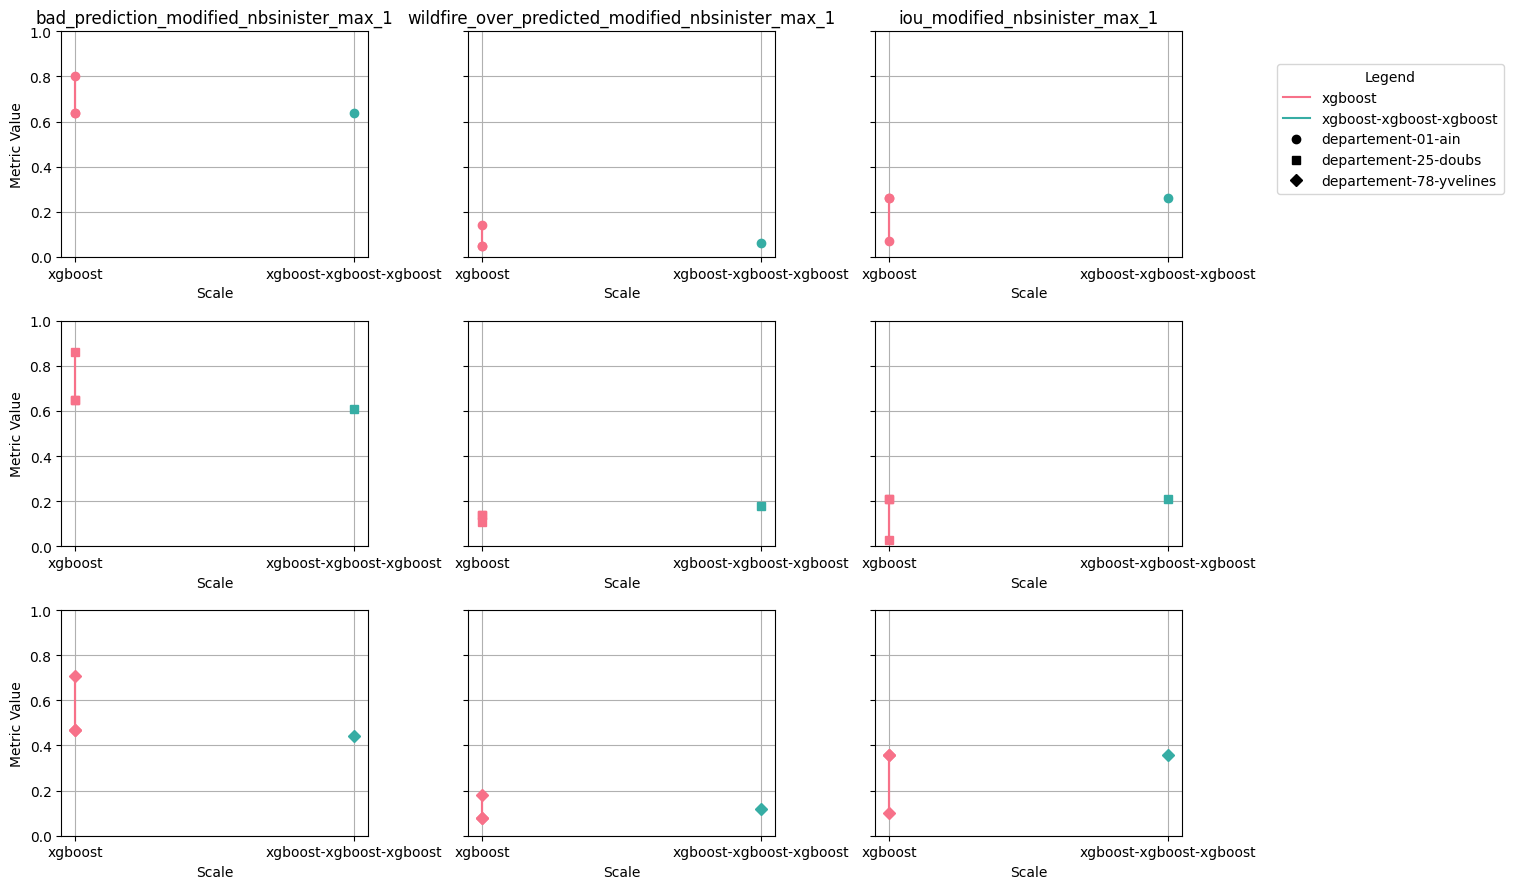

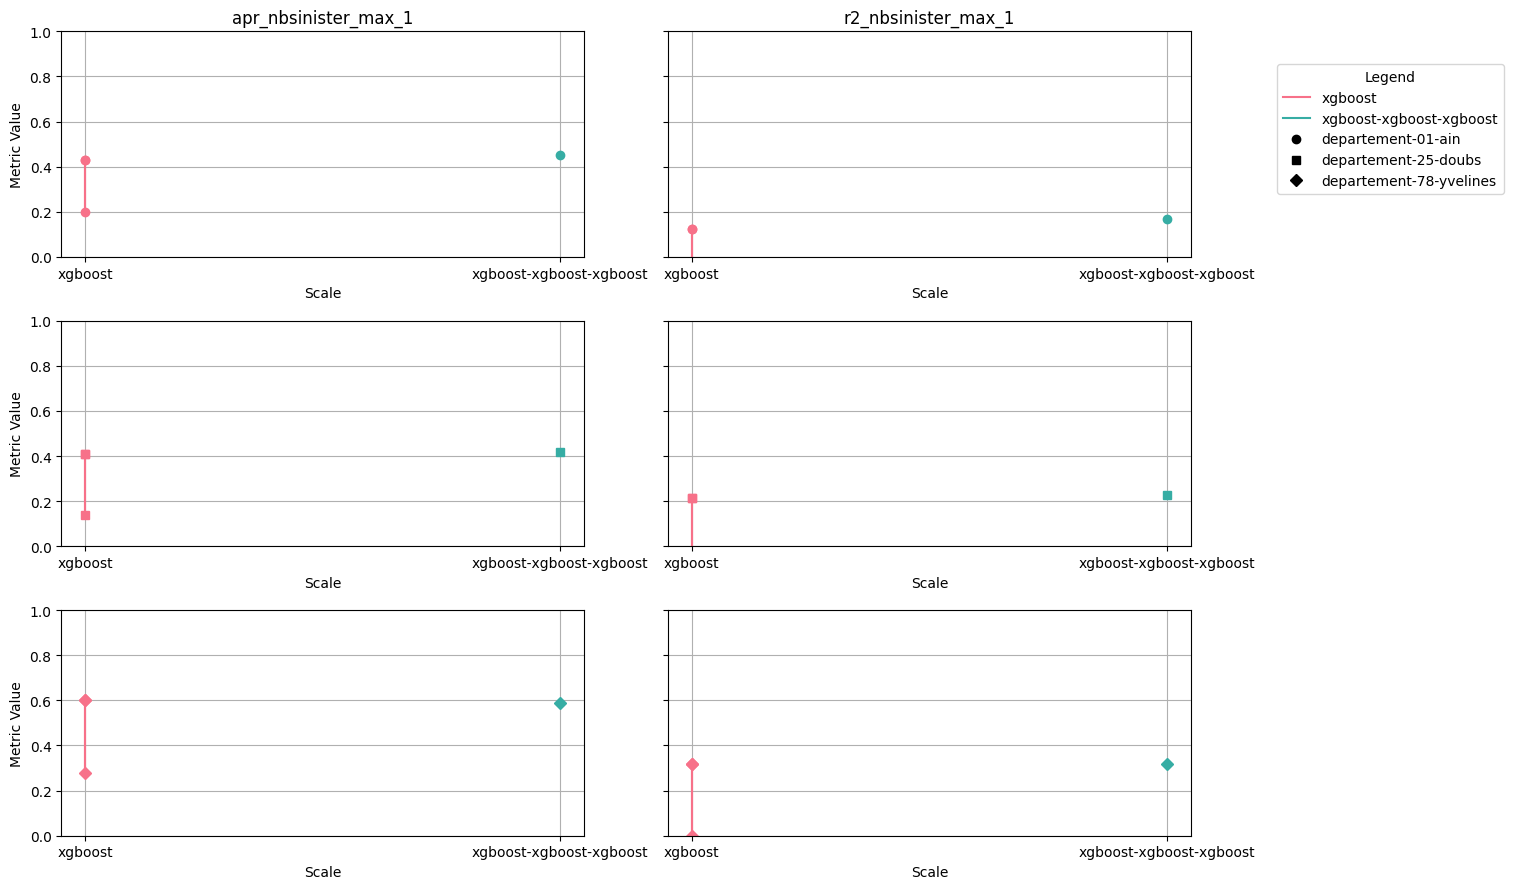

In [28]:
# Define markers for each department
dept_markers = {
    'departement-01-ain': 'o',   # Circle
    'departement-25-doubs': 's',   # Square
    'departement-78-yvelines': 'D',   # Diamond
    # Add more departments and their markers as needed
}
metrics =  ['bad_prediction_modified_nbsinister_max_1', 'wildfire_over_predicted_modified_nbsinister_max_1', 'iou_modified_nbsinister_max_1']

compare_models2(df, df.Department.unique(), dept_markers, metrics, 'Model', Path('./'), '1')

metrics =  ['apr_nbsinister_max_1', 'r2_nbsinister_max_1']

compare_models2(df, df.Department.unique(), dept_markers, metrics, 'Model', Path('./'), '1')

ValueError: could not convert string to float: 'xgboost'

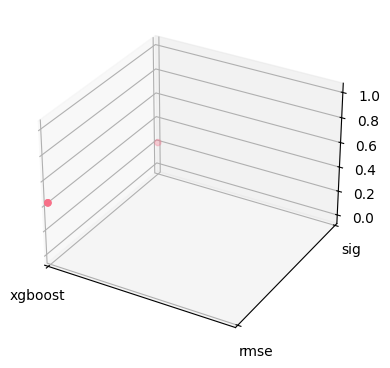

In [32]:
compare_models_3d(df, df.Department.unique(), dept_markers, metrics, 'Model', 'Loss_function')

###